In [113]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import lmfit
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = 15, 8
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
markerlist = ["d", "x", "o"]


wsat_uni = 164.4
wsat_multi = 278
gamma = 0.07258
cos_theta = 1

def laplace(p):
    return (2 * gamma)/p


def unimodal(p,a,n,m):
    return wsat_uni *(1+(a*p)**n)**(-m)

def dwdpc(p,a,n,m):
    return -((m*n*(a*p)**(n)*((a*p)**n + 1)**(-m-1))/p)

def fv_r_uni(p,a,n,m, wsat):
    return -wsat * dwdpc(p,a,n,m) * np.log(10) * p


def fv_r_inter(p,l1,l2,l3,a1,a2,a3,m1,m2,m3,n1,n2,n3,wsat):
    f1 = -wsat * l1 * dwdpc(p,a1,n1,m1) * np.log(10) * p
    f2 = -wsat * l2 * dwdpc(p,a2,n2,m2) * np.log(10) * p
    f3 = -wsat * l3 * dwdpc(p,a3,n3,m3) * np.log(10) * p
    return f1 + f2 + f3

def fv_r_multi_fit(p,pars, wsat):
    parvals = pars.valuesdict()
    l1,l2,l3 = parvals["l1"], parvals["l2"], parvals["l3"]
    a1,a2,a3 = parvals["a1"], parvals["a2"], parvals["a3"]
    m1,m2,m3 = parvals["m1"], parvals["m2"], parvals["m3"]
    n1,n2,n3 = parvals["n1"], parvals["n2"], parvals["n3"] 
    f1 = -wsat * l1 * dwdpc(p,a1,n1,m1) * np.log(10) * p
    f2 = -wsat * l2 * dwdpc(p,a2,n2,m2) * np.log(10) * p
    f3 = -wsat * l3 * dwdpc(p,a3,n3,m3) * np.log(10) * p
    return f1 + f2 + f3

def multimodal(p,l1,l2,l3,a1,a2,a3,m1,m2,m3,n1,n2,n3):
    f1 =  wsat_multi * l1 * (1+(a1*p)**n1)**(-m1)
    f2 =  wsat_multi * l2 * (1+(a2*p)**n2)**(-m2)
    f3 =  wsat_multi * l3 * (1+(a3*p)**n3)**(-m3)
    return f1 + f2 + f3

def plot_multimodal(l1,l2,l3,a1,a2,a3,m1,m2,m3,n1,n2,n3):
    x = np.linspace(3,9,100)
    y = multimodal(10**x,l1,l2,l3,a1,a2,a3,m1,m2,m3,n1,n2,n3)
    fig, ax = plt.subplots(2,1, figsize=(15, 16))
    ax[0].plot(x, y, label="Fit")
    i=0
    for group in grouped_multi:
        ax[0].errorbar(group[1]["log pc"], group[1]["w"], yerr=group[1]["sigma"],fmt=markerlist[i], label=group[0])
        i+=1
    ax[0].set_ylabel("Moisture Content [kg/m^3]")
    ax[0].set_xlabel("Capillary Pressure [log(Pa)]")
    ax[0].grid()
    ax[0].legend()
    ax[1].plot(np.log10(laplace(10**x)), fv_r_inter(10**x,l1,l2,l3,a1,a2,a3,m1,m2,m3,n1,n2,n3,wsat_multi), "o-")
    ax[1].grid()
    ax[1].set_ylabel("fv(r)")
    ax[1].set_xlabel("log r [log m]")
    
    
    
def multimodal_fit(pars, x, data=None, eps=None):
    parvals = pars.valuesdict()
    l1,l2,l3 = parvals["l1"], parvals["l2"], parvals["l3"]
    a1,a2,a3 = parvals["a1"], parvals["a2"], parvals["a3"]
    m1,m2,m3 = parvals["m1"], parvals["m2"], parvals["m3"]
    n1,n2,n3 = parvals["n1"], parvals["n2"], parvals["n3"]
    f1 =  wsat_multi * l1 * (1+(a1*x)**n1)**(-m1)
    f2 =  wsat_multi * l2 * (1+(a2*x)**n2)**(-m2)
    f3 =  wsat_multi * l3 * (1+(a3*x)**n3)**(-m3)
    model = f1 + f2 + f3
    if data is None:
        return model
    if eps is None:
        return (model - data)**2
    return (model-data)**2 / eps
    
    
def plot_uni(a,n,m):
    x= np.linspace(3,9,100)
    y = unimodal(10**x,a,n,m)
    fig, ax = plt.subplots(2,1, figsize=(15, 16))
    ax[0].plot(x, y, label="Fit")
    i=0
    for group in grouped:
        ax[0].errorbar(group[1]["log pc"], group[1]["w"], yerr=group[1]["sigma"],fmt="x", label=group[0])
        i+=1
    ax[0].legend()
    ax[0].grid()
    ax[0].set_ylabel("Moisture Content [kg/m^3]")
    ax[0].set_xlabel("Capillary Pressure [log(Pa)]")
    ax[1].plot(np.log10(laplace(10**x)), fv_r_uni(10**x, a,n,m, wsat_uni), "o-")
    ax[1].grid()
    ax[1].set_ylabel("fv(r)")
    ax[1].set_xlabel("log r [log m]")
    
    
    
data_uni = pd.read_csv("raw_unimodal.csv")
data_multimodal = pd.read_csv("raw_multimodal.csv")
subset = data_uni[["log pc","w","sigma","regime"]]


# Unimodal (Brick)

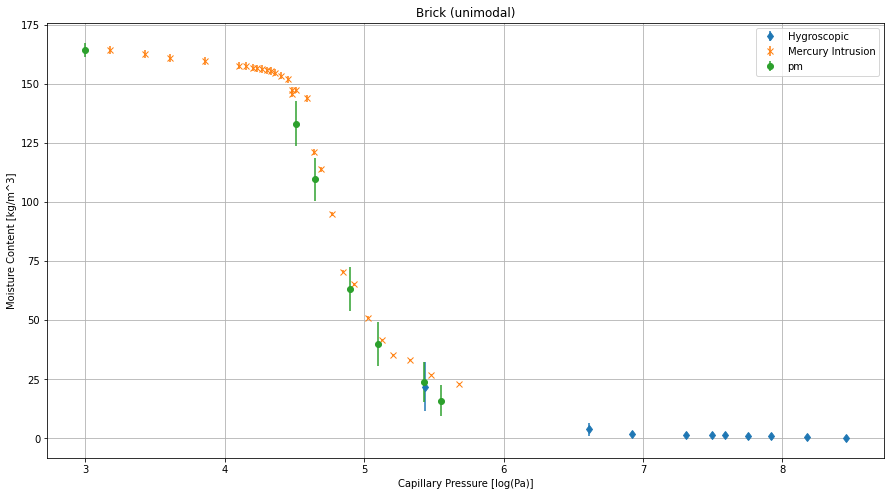

In [77]:

grouped = subset.groupby("regime")
m=0
for group in grouped:
    plt.errorbar(group[1]["log pc"], group[1]["w"], yerr=group[1]["sigma"],fmt=markerlist[m], label=group[0])
    m+=1
plt.ylabel("Moisture Content [kg/m^3]")
plt.xlabel("Capillary Pressure [log(Pa)]")
plt.title("Brick (unimodal)")
plt.legend()
plt.grid()

In [97]:
interactive_plot = interactive(plot_uni, m=FloatSlider(min=0, max=1, value=0.2,continuous_update=False), n=FloatSlider(min=1, max=20, value=1,continuous_update=False),
                               a =FloatSlider(min=1e-6, max=1e-4,step=1e-8, readout_format=".5e",continuous_update=False))
output = interactive_plot.children[-1]
output.layout.height = '1050px'
interactive_plot

interactive(children=(FloatSlider(value=1e-06, continuous_update=False, description='a', max=0.0001, min=1e-06…

## Optimal Fit

Parameters:
a: 3.708239536344911e-05, n: 7.512525198215954, m: 0.10326546057827807


Text(0.5, 0.98, 'Brick (unimodal)')

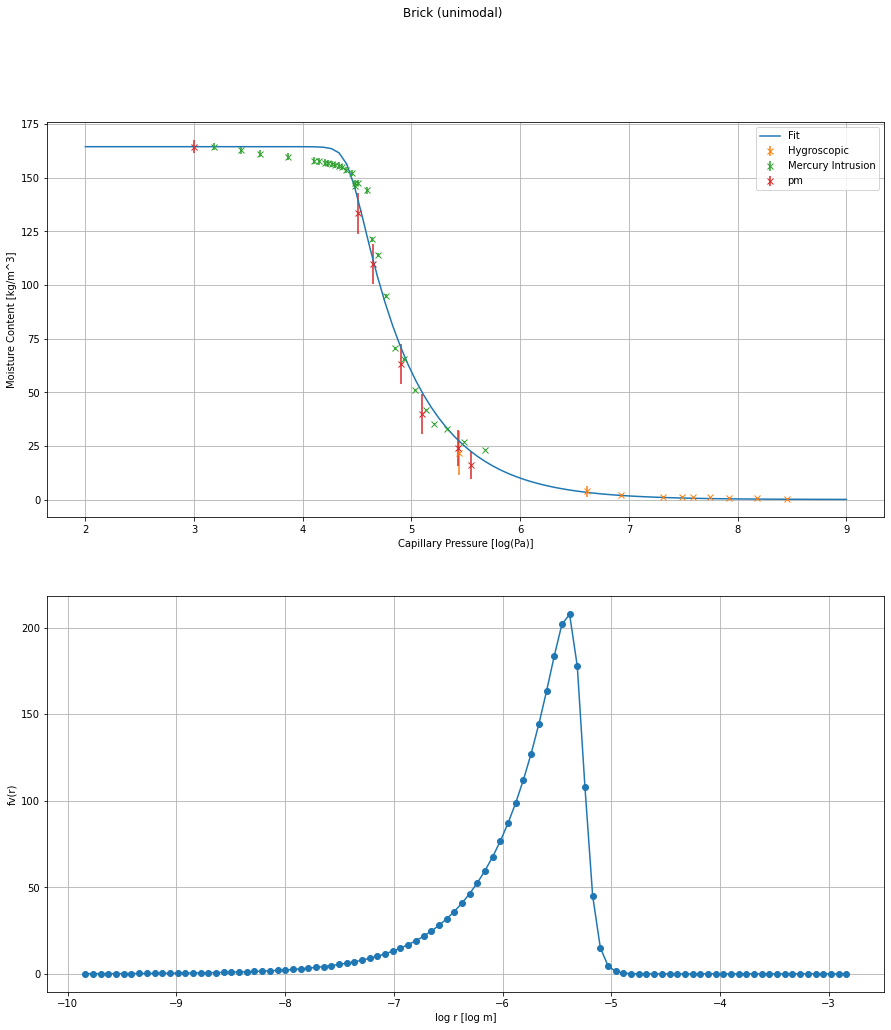

In [94]:
popt, pcov = curve_fit(unimodal, 10**subset["log pc"], subset["w"],sigma=subset["sigma"], bounds=(0, np.inf), p0 = [1, 1, 1])
x= np.linspace(2,9,100)
fig, ax = plt.subplots(2,1, figsize=(15, 16))
ax[0].plot(x, unimodal(10**x, *popt), label="Fit")
for group in grouped:
    ax[0].errorbar(group[1]["log pc"], group[1]["w"], yerr=group[1]["sigma"],fmt="x", label=group[0])
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel("Moisture Content [kg/m^3]")
ax[0].set_xlabel("Capillary Pressure [log(Pa)]")
ax[1].plot(np.log10(laplace(10**x)), fv_r_uni(10**x, *popt, wsat_uni), "o-")
ax[1].grid()
ax[1].set_ylabel("fv(r)")
ax[1].set_xlabel("log r [log m]")
print("Parameters:")
print("a: {}, n: {}, m: {}".format(popt[0], popt[1], popt[2]))
plt.suptitle("Brick (unimodal)")


# Multimodal (Mortar)

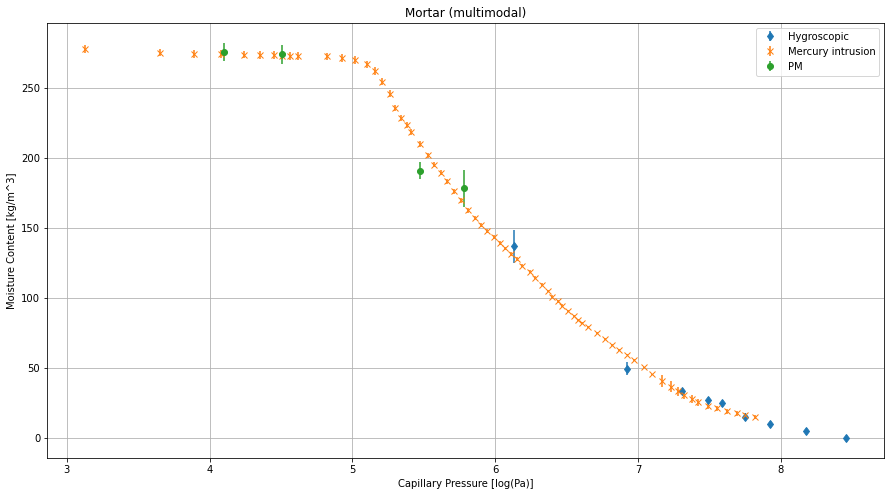

In [98]:
subset_multi = data_multimodal[["log pc","w","sigma","regime"]]
grouped_multi = subset_multi.groupby("regime")
m=0
for group in grouped_multi:
    plt.errorbar(group[1]["log pc"], group[1]["w"], yerr=group[1]["sigma"],fmt=markerlist[m], label=group[0])
    m+=1
plt.ylabel("Moisture Content [kg/m^3]")
plt.xlabel("Capillary Pressure [log(Pa)]")
plt.title("Mortar (multimodal)")
plt.grid()
plt.legend()

In [114]:
interactive_plot = interactive(plot_multimodal, 
                               l1 = FloatSlider(min=0, max=1, value=0.3,continuous_update=False),
                               l2 = FloatSlider(min=0, max=1, value=0.3,continuous_update=False),
                               l3 = FloatSlider(min=0, max=1, value=0.3,continuous_update=False),
                               m1=FloatSlider(min=0, max=1, value=0.2,continuous_update=False),
                               m2=FloatSlider(min=0, max=1, value=0.2,continuous_update=False), 
                               m3=FloatSlider(min=0, max=1, value=0.2,continuous_update=False),
                               n1=FloatSlider(min=1, max=20, value=1,continuous_update=False),
                               n2=FloatSlider(min=1, max=20, value=1,continuous_update=False),
                               n3=FloatSlider(min=1, max=20, value=1,continuous_update=False),
                               a1 =FloatSlider(min=1e-6, max=1e-4,step=1e-8, readout_format=".5e",continuous_update=False),
                               a2 =FloatSlider(min=1e-6, max=1e-4,step=1e-8, readout_format=".5e",continuous_update=False),
                               a3 =FloatSlider(min=1e-6, max=1e-4,step=1e-8, readout_format=".5e",continuous_update=False))

output = interactive_plot.children[-1]
output.layout.height = '1050px'
interactive_plot

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='l1', max=1.0), FloatSlider(…

## Optimal Fit

In [115]:
size = np.array([10.0,120.0,500.0]) * 0.00000001



p = lmfit.Parameters()
p.add_many(('a1', size[0],True, size[0]/5,  size[0]*5, None, None),
           ('a2', size[1],True, size[1]/5, size[1]*5, None, None), 
           ('a3', size[2],True, size[2]/5, size[2]*5, None, None), 
           ('l1', 1/3, True, 0,None, None, None),
           ('l2', 1/3, True, 0,None, None, None),
           ('l3', 1/3, True, 0,None, None, None), 
           ('l_sum', 1, True, 0, None, "(l1 + l2 + l3)", None),
           ('l_constraint', 0, True, 0, 0.0000001, "1-l_sum", None),
           ('n1', 1.1,True, 1, None, None, None), 
           ('n2', 31., True, 1, None, None, None), 
           ('n3', 1.1, True, 1, None, None, None), 
           #('m1', 0.5, False, None, None, "1-1/n1", None),
           #('m2', 0.5, False, None, None, "1-1/n2", None),
           #('m3', 0.5, False, None, None, "1-1/n3", None))
           ('m1', 0.5, True, 0, None, None, None),
           ('m2', 0.5, True, 0, None, None, None),
           ('m3', 0.5, True, 0, None, None, None))

        



minner = lmfit.Minimizer(multimodal_fit, p, fcn_args=(10**subset_multi["log pc"], subset_multi["w"], subset_multi["sigma"]))

In [116]:
fit = minner.minimize()

Text(0.5, 0, 'log r [log m]')

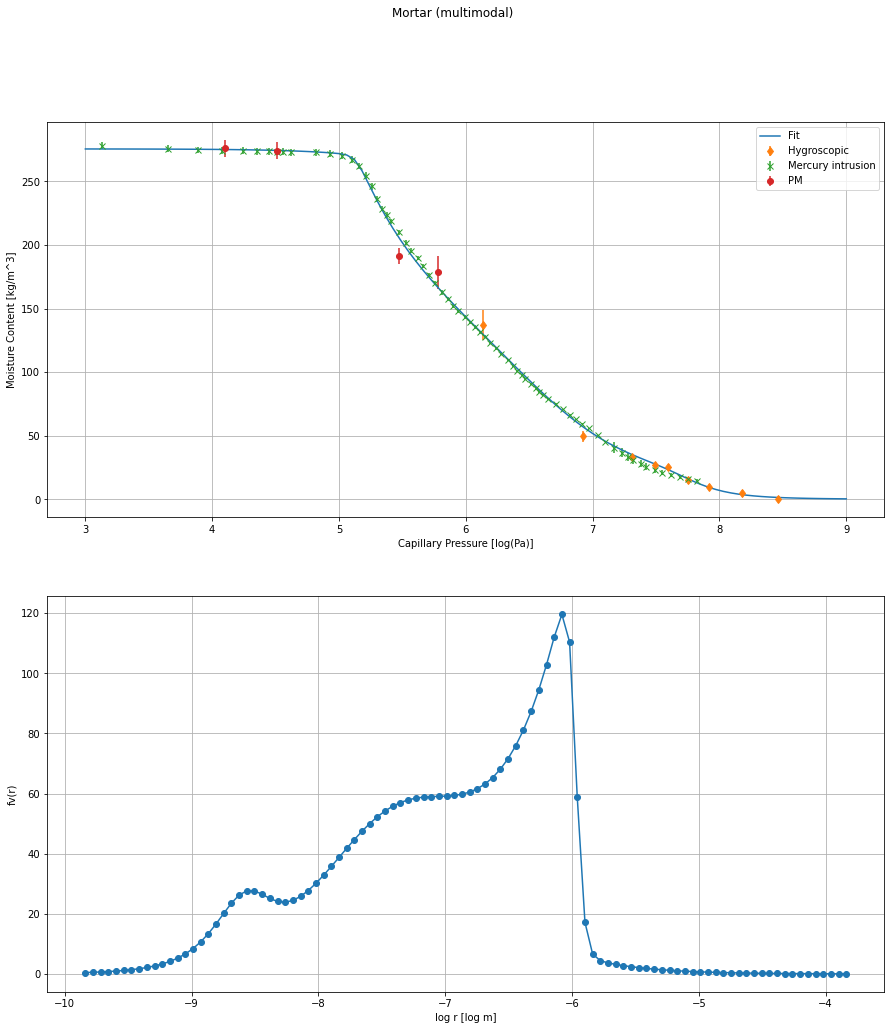

In [117]:
subset_multi = data_multimodal[["log pc","w","sigma","regime"]]
grouped_multi = subset_multi.groupby("regime")
m=0
x= np.linspace(3,9,100)
fig, ax = plt.subplots(2,1, figsize=(15, 16))
fig.suptitle("Mortar (multimodal)")
ax[0].plot(x, multimodal_fit(fit.params, 10**x), label='Fit')
for group in grouped_multi:
    ax[0].errorbar(group[1]["log pc"], group[1]["w"], yerr=group[1]["sigma"],fmt=markerlist[m], label=group[0])
    m+=1
ax[0].set_ylabel("Moisture Content [kg/m^3]")
ax[0].set_xlabel("Capillary Pressure [log(Pa)]")
ax[0].grid()
ax[0].legend()
ax[1].plot(np.log10(laplace(10**x)), fv_r_multi_fit(10**x, fit.params, wsat_uni), "o-")
ax[1].grid()
ax[1].set_ylabel("fv(r)")
ax[1].set_xlabel("log r [log m]")

In [118]:
print("Parameters and Statistics: ")
print(lmfit.fit_report(fit))

Parameters and Statistics: 
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3437
    # data points      = 83
    # variables        = 12
    chi-square         = 3029.61906
    reduced chi-square = 42.6706910
    Akaike info crit   = 322.580180
    Bayesian info crit = 351.606267
##  Warning: uncertainties could not be estimated:
    a1:            at boundary
    a2:            at boundary
    n2:            at boundary
[[Variables]]
    a1:            2.0000e-08 (init = 1e-07)
    a2:            2.4000e-07 (init = 1.2e-06)
    a3:            7.3104e-06 (init = 5e-06)
    l1:            0.06503658 (init = 0.3333333)
    l2:            0.45894889 (init = 0.3333333)
    l3:            0.46717469 (init = 0.3333333)
    l_sum:         0.99116017 == '(l1 + l2 + l3)'
    l_constraint:  1.0000e-07 == '1-l_sum'
    n1:            3.42770075 (init = 1.1)
    n2:            1.00000000 (init = 31)
    n3:            13.7421260 (init = 1.1)
    m1:            0.661049